<a href="https://colab.research.google.com/github/kvamsi7/mscs/blob/mscs_nn_prj/CS5720-Neural%20Network%20and%20Deep%20Learning/NN_Final_Project/DL_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, LSTM, Flatten,Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix,classification_report
from keras.callbacks import ReduceLROnPlateau
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
import pickle
import nltk
from nltk.corpus import stopwords,wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from string import punctuation

### Load Data

In [ ]:
dataset_path_1 = r'/content/Restaurant_Reviews.tsv'
dataset_path_2 = r'/content/Restaurant reviews.csv'

In [ ]:
data_set_1 = pd.read_csv(dataset_path_1,delimiter='\t')
data_set_2 = pd.read_csv(dataset_path_2,usecols=['Review','Rating'])

### Data Cleaning and Preprocessing

In [ ]:
# Discard all rows with null values
data_set_2 = data_set_2.dropna()

In [ ]:
data_set_2.Rating.value_counts()

Rating
5       3826
4       2373
1       1735
3       1192
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: count, dtype: int64

In [ ]:
# drop like
data_set_2 = data_set_2.drop(data_set_2[data_set_2.Rating == 'Like'].index)

In [ ]:
data_set_2['Rating']=pd.to_numeric(data_set_2['Rating'])

In [ ]:
# analysis on the label

# create a feature with categorical reviews
def format_rating(rating):
    if rating < 3:
        return 0
    elif rating >= 3:
        return 1

category = data_set_2['Rating'].apply(format_rating)


In [ ]:
data_set_2['Liked'] = pd.to_numeric(category,downcast='integer')

In [ ]:
data_set_2 = data_set_2.drop('Rating',axis = 1)

In [ ]:
# pd.merge(data_set_1,data_set_2,on='key')
data_set = pd.concat([data_set_1,data_set_2],ignore_index=True)

In [ ]:
data_set.to_csv('data_set_c.csv')

In [ ]:
# Function to check if a string contains emojis
def contains_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

# Filter reviews containing emojis
emojis_reviews = data_set['Review'][data_set['Review'].apply(contains_emoji)]

In [ ]:
emojis_reviews.shape

(708,)

In [ ]:
# remove the emoji from the text

# Function to remove emojis from a text while preserving attached words
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data_set['Review'] = data_set['Review'].apply(remove_emojis)

In [ ]:
# save the data

# data_set.to_csv("cleaned_rest_review.csv")

In [3]:
# loading saved data
data_set = pd.read_csv("/content/cleaned_rest_review.csv")

In [4]:
data_set = data_set[~data_set['Review'].isna()]
data_set.reset_index(inplace=True)

In [5]:
# helper function to get simple pos
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [6]:
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
# lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# adding punctuations to stopwords
stop_words.update(list(punctuation))

def clean_review(words):
    output_words = []
    for word in words:
        # to store the output words
        if word.lower() not in stop_words:
            # actual pos
            pos = pos_tag([word])   # passing the word as an array because pos_tag expect and array of words,
                                    # otherwise will get the pos_tag of each character in the word
            # simple pos
            pos = get_simple_pos(pos[0][1])  # the position of the tag is 1 in the tuple of pos which is the output from above statement
            clean_word = lemmatizer.lemmatize(word,pos)
            output_words.append(clean_word.lower())
    return output_words

In [8]:
# build the corpus
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
all_stopwords = set(all_stopwords)
all_stopwords.update(list(punctuation))

In [9]:
# an array to append all the cleaned text as corpus

def get_corpus(data):
    corpus = []

    for i in range(0, len(data)):
        review = re.sub(r'[^a-zA-Z]',' ',data[i])
        review = review.lower().split()
        output_words = []
        for word in review:
          if word.lower() not in all_stopwords:
            pos = pos_tag([word])
            pos = get_simple_pos(pos[0][1])
            clean_word = lemmatizer.lemmatize(word,pos)
            output_words.append(clean_word)
        review = ' '.join(output_words)
        corpus.append(review)
    return corpus

In [10]:
corpus = get_corpus(data_set['Review'])

### Data Transformation

In [11]:
# Convert labels to binary
max_features = 10000
oov_token = "<OOV>"
max_len = 100
padding_type='post'
truncation_type='post'

tokenizer = Tokenizer(num_words=max_features, split=' ',oov_token=oov_token)
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)

X = pad_sequences(X,maxlen=max_len,padding=padding_type,truncating=truncation_type)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data_set['Liked'])

Embedding process

In [12]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2024-04-23 15:01:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-23 15:01:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-23 15:01:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [13]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [14]:
import numpy as np
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, max_len))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [16]:
# saving tokenizer
tokenizer_path = 'tokenizer_try.pkl'
pickle.dump(tokenizer,open(tokenizer_path,'wb'))

In [17]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
%load_ext tensorboard

log_folder = 'logs'

In [19]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(word_index)+1,
                         output_dim=max_len,
                         weights=[embedding_matrix],
                         input_length=max_len,
                         trainable = False))
lstm_model.add(Bidirectional(LSTM(units=150,dropout=0.5,return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(units=256,dropout=0.2)))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



# callback
callbacks = [EarlyStopping(monitor='val_loss',patience=5),
             ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3),
             TensorBoard(log_dir=log_folder)]
# Train LSTM model
history = lstm_model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=25, batch_size=32, callbacks = callbacks,verbose=2)

Epoch 1/25
274/274 - 20s - loss: 0.3924 - accuracy: 0.8260 - val_loss: 0.2876 - val_accuracy: 0.8758 - lr: 0.0010 - 20s/epoch - 74ms/step
Epoch 2/25
274/274 - 8s - loss: 0.3270 - accuracy: 0.8589 - val_loss: 0.5936 - val_accuracy: 0.7699 - lr: 0.0010 - 8s/epoch - 28ms/step
Epoch 3/25
274/274 - 7s - loss: 0.3162 - accuracy: 0.8622 - val_loss: 0.2519 - val_accuracy: 0.8945 - lr: 0.0010 - 7s/epoch - 25ms/step
Epoch 4/25
274/274 - 7s - loss: 0.2787 - accuracy: 0.8788 - val_loss: 0.2499 - val_accuracy: 0.8913 - lr: 0.0010 - 7s/epoch - 25ms/step
Epoch 5/25
274/274 - 8s - loss: 0.2584 - accuracy: 0.8904 - val_loss: 0.2372 - val_accuracy: 0.9009 - lr: 0.0010 - 8s/epoch - 30ms/step
Epoch 6/25
274/274 - 7s - loss: 0.2469 - accuracy: 0.8939 - val_loss: 0.2268 - val_accuracy: 0.9119 - lr: 0.0010 - 7s/epoch - 25ms/step
Epoch 7/25
274/274 - 8s - loss: 0.2382 - accuracy: 0.8974 - val_loss: 0.2550 - val_accuracy: 0.9005 - lr: 0.0010 - 8s/epoch - 29ms/step
Epoch 8/25
274/274 - 7s - loss: 0.2302 - accur

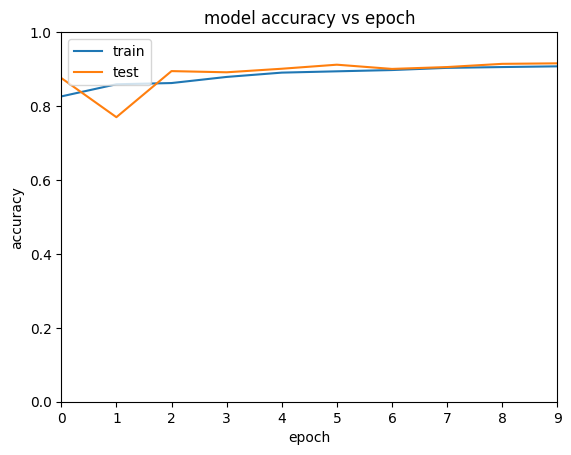

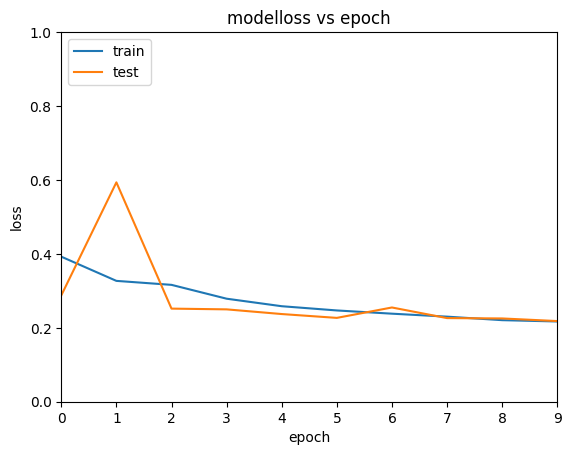

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'model accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xlim(0,15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'modelloss vs epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xlim(0,15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print("LSTM Test Accuracy:", lstm_accuracy)


69/69 [==============================] - 1s 12ms/step - loss: 0.2291 - accuracy: 0.9087
LSTM Test Accuracy: 0.9086757898330688


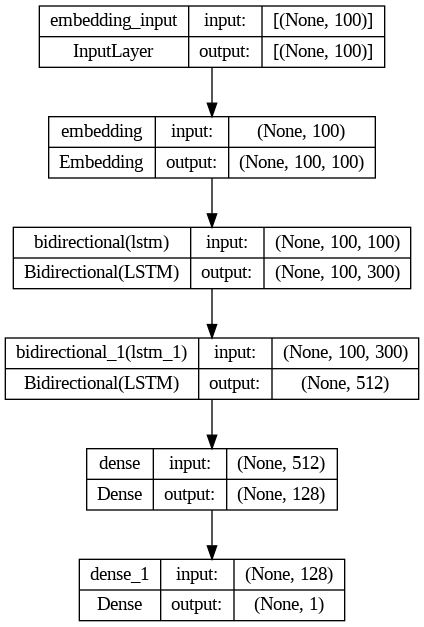

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
import keras

keras.utils.plot_model(lstm_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1232500   
                                                                 
 bidirectional (Bidirection  (None, 100, 300)          301200    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               1140736   
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2740229 (10.45 MB)
Trainable params: 15077

In [24]:
# saving the model
lstm_model.save("lstm_90.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# load saved model

def build_model():
    # Define LSTM model
    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim=len(word_index)+1,
                            output_dim=max_len,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable = False))
    lstm_model.add(Bidirectional(LSTM(units=150,dropout=0.5,return_sequences=True)))
    lstm_model.add(Bidirectional(LSTM(units=150,dropout=0.2)))
    lstm_model.add(Dense(128, activation='relu'))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return lstm_model


test_model = build_model()
test_model.load_weights('/content/lstm_91.h5')

In [26]:
y_pred_lstm = np.array([1 if y_p > 0.5 else 0 for y_p in lstm_model.predict(X_test)])

69/69 [==============================] - 4s 16ms/step


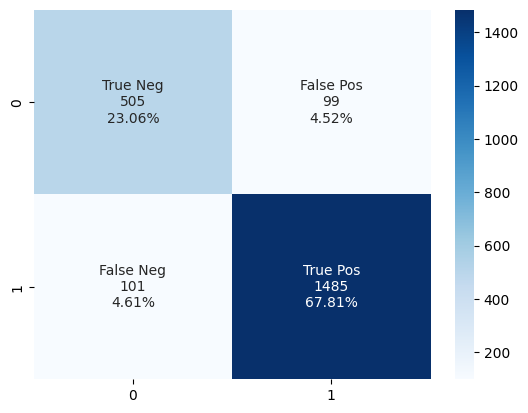

In [27]:
# confusion matrix on lstm model
cf_matrix = confusion_matrix(y_test,y_pred_lstm)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.show()

In [28]:
print("lstm classification report",classification_report(y_test,y_pred_lstm))

lstm classification report               precision    recall  f1-score   support

           0       0.83      0.84      0.83       604
           1       0.94      0.94      0.94      1586

    accuracy                           0.91      2190
   macro avg       0.89      0.89      0.89      2190
weighted avg       0.91      0.91      0.91      2190



In [ ]:
#############################

In [29]:
def single_prediction(review,model):

  # input_vector = cv.transform(input_text).toarray()
  input_vector_test = tokenizer.texts_to_sequences(review)

  input_vector_seq = pad_sequences(input_vector_test,maxlen=max_len)

  # LSTM model prediction
  prediction = model.predict(input_vector_seq)[0][0]
  treshold = 0.5
  if prediction >= 0.5:
      print('LSTM: Review is Positive')
  else:
      print('LSTM: Review is Negative')

In [30]:
review_test_p = ["I recently had the pleasure of dining here, and it was an experience that exceeded all my expectations. From the moment we walked in, the ambiance set the stage for what was to be a memorable evening. The staff greeted us warmly, ensuring we felt welcomed and valued.The menu selection was impressive, offering a variety of dishes that catered to all preferences, including several innovative options for those with dietary restrictions. Each dish we ordered was a testament to the chef's expertise and passion for culinary excellence. The flavors were balanced perfectly, with each ingredient shining through without overpowering the others.What truly set this place apart was the attention to detail. The presentation of the food was artistic, the timing between courses was impeccable, and the staff went above and beyond to accommodate our requests, making us feel truly special.I cannot recommend this place enough. Whether you’re looking for a place to celebrate a special occasion or just in search of a delightful dining experience, this should be at the top of your list. We’re already looking forward to our next visit!"]
review_test_n = ["Unfortunately, my recent visit to the restaurant left much to be desired. Despite the high expectations set by its reputation, the experience was underwhelming from start to finish. Upon arrival, the greeting was lukewarm, and it took a noticeable amount of time before we were seated, despite having reservations.The menu, while extensive, seemed to lack coherence, and the descriptions did little to entice the palate or clarify what one might expect from each dish. When our orders finally arrived, the presentation was lackluster, and the flavors were surprisingly bland. A particular disappointment was the main course, which was not only overcooked but also arrived lukewarm, suggesting it had been sitting out for some time.Service throughout the evening was inconsistent; our server seemed disinterested and was seldom seen. Attempts to address our concerns about the meal were met with indifference, leaving us feeling unvalued as customers.Given the price point and the establishment's reputation, I expected a dining experience that delighted the senses and showcased culinary excellence. Unfortunately, what I encountered was a forgettable meal paired with service that failed to meet even basic standards of hospitality. It's unlikely I'll return or recommend this restaurant to others based on this visit."]
review_test_neu = ["My recent visit to the restaurant was a mixed experience. Walking in, the ambiance of the place was inviting, with a nicely decorated interior that promised a cozy dining atmosphere. The staff greeted us politely and seated us without delay, which was a good start to the evening.The menu presented a wide array of options, ranging from traditional favorites to some intriguing chef specials. It took some time to make our selections, partly due to the variety and partly because the menu descriptions could have been more detailed.When the food arrived, the presentation was decent, and the portions were generous. Some of the dishes we tried were quite satisfying, offering a good balance of flavors and freshness. However, a few items fell short of expectations, lacking the depth of flavor we anticipated. It was a hit or miss on the culinary front.Service was generally efficient, though it lacked the warmth and attentiveness that elevate a dining experience from good to great. Our server was courteous but seemed rushed, making our interactions feel somewhat transactional.The overall value for the money was fair, considering the portion sizes and the quality of the ingredients used. However, the inconsistency in the food and service left us feeling that while the restaurant has potential, there's room for improvement in execution and attention to detail.In conclusion, while the visit didn't fully meet our expectations, it wasn't a disappointing experience either. For those considering dining here, there might be dishes that delight, but I'd recommend managing your expectations when it comes to service and some menu items."]

In [31]:
corp_test_sample = get_corpus(review_test_neu)

In [32]:
single_prediction(corp_test_sample,lstm_model)

1/1 [==============================] - 0s 37ms/step
LSTM: Review is Positive
